# 0. Imports and Load Data

In [30]:
import os
import glob
import random
import json
from pathlib import Path
import pandas as pd
import yaml
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
import warnings

warnings.filterwarnings('ignore')

In [31]:
DATA_YAML_PATH = "../data/data.yaml"

assert os.path.exists(DATA_YAML_PATH), f"data.yaml not found in {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': '../data/train/images',
 'val': '../data/valid/images',
 'test': '../data/test/images',
 'nc': 17,
 'names': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'roboflow': {'workspace': 'srafil-ar',
  'project': 'forklift-6ms6v',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/srafil-ar/forklift-6ms6v/dataset/1'}}

In [32]:
train_dir = data_cfg.get("train")
val_dir   = data_cfg.get("val")
test_dir  = data_cfg.get("test", None)
class_names = data_cfg.get("names", [])
nc = int(data_cfg.get("nc", len(class_names)))

print("Train images dir:", train_dir)
print("Val images dir  :", val_dir)
print("Test images dir :", test_dir)
print("Classes (nc)     :", nc)
print("Classes name:", class_names)

Train images dir: ../data/train/images
Val images dir  : ../data/valid/images
Test images dir : ../data/test/images
Classes (nc)     : 17
Classes name: ['car', 'cardboard box', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


# 1. Data Analysis: First Sight

In [33]:
def yolo_label_paths(img_dir: str) -> list:
    img_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    label_paths = []
    for ip in img_paths:
        lp = ip.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
        lp = os.path.splitext(lp)[0] + ".txt"
        label_paths.append((ip, lp))
    return label_paths

def read_yolo_labels(label_path: str):
    if not os.path.exists(label_path):
        return []
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
                rows.append((cls_id, cx, cy, w, h))
    return rows


In [34]:
def analyze_split(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    per_class = Counter()
    objs_per_image = []
    areas = []

    for _, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        objs_per_image.append(len(labels))
        for (cls_id, cx, cy, w, h) in labels:
            per_class[cls_id] += 1
            areas.append(w * h)

    df_classes = pd.DataFrame({
        "class_id": list(per_class.keys()),
        "count": list(per_class.values())
    })
    df_classes["class_name"] = df_classes["class_id"].apply(lambda i: class_names[i] if i < len(class_names) else str(i))

    df_objs = pd.DataFrame({"objects_per_image": objs_per_image})
    df_areas = pd.DataFrame({"bbox_area_norm": areas})

    return df_classes.sort_values("count", ascending=False), df_objs, df_areas

df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(    class_id  count         class_name
 3          2  24213           forklift
 2          8  20480             person
 0          1   1266      cardboard box
 13        12   1023       traffic cone
 1          3    447  freight container,
        objects_per_image
 count       20546.000000
 mean            2.405237
 std             2.472610
 min             1.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max            47.000000,
        bbox_area_norm
 count    49418.000000
 mean         0.155603
 std          0.224430
 min          0.000010
 25%          0.010547
 50%          0.045352
 75%          0.203203
 max          1.000000)

### How is the date distribuited?

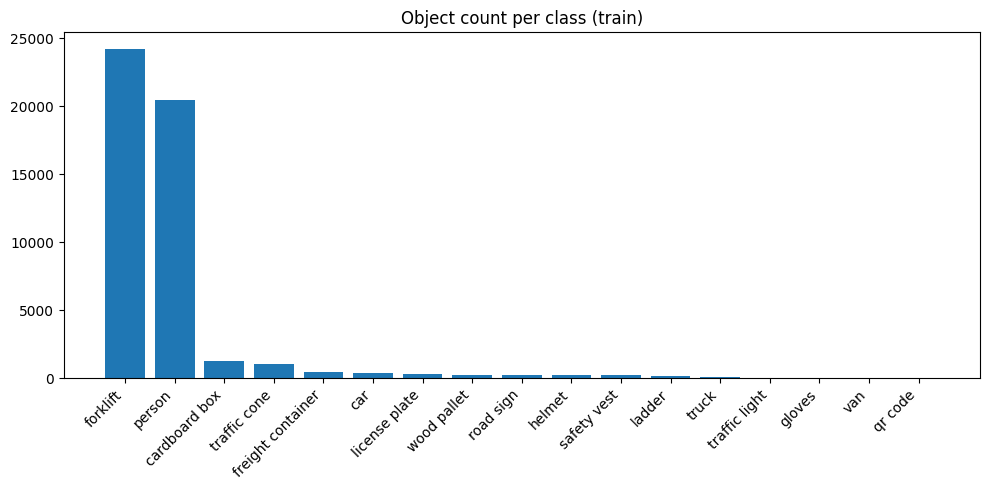

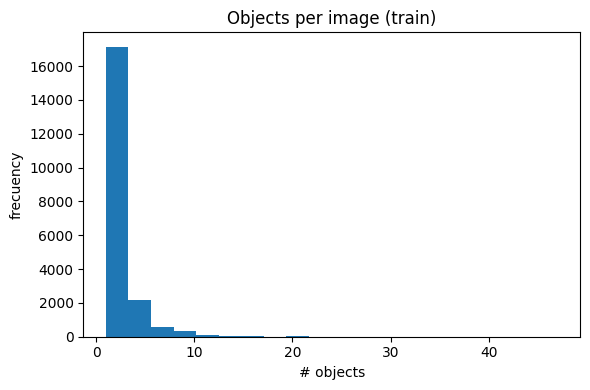

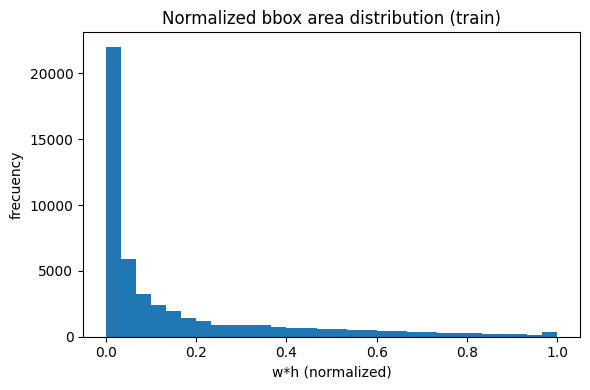

In [35]:
plt.figure(figsize=(10,5))
plt.bar(df_classes_train["class_name"], df_classes_train["count"])
plt.xticks(rotation=45, ha='right')
plt.title("Object count per class (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_objs_train["objects_per_image"], bins=20)
plt.title("Objects per image (train)")
plt.xlabel("# objects")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_areas_train["bbox_area_norm"], bins=30)
plt.title("Normalized bbox area distribution (train)")
plt.xlabel("w*h (normalized)")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

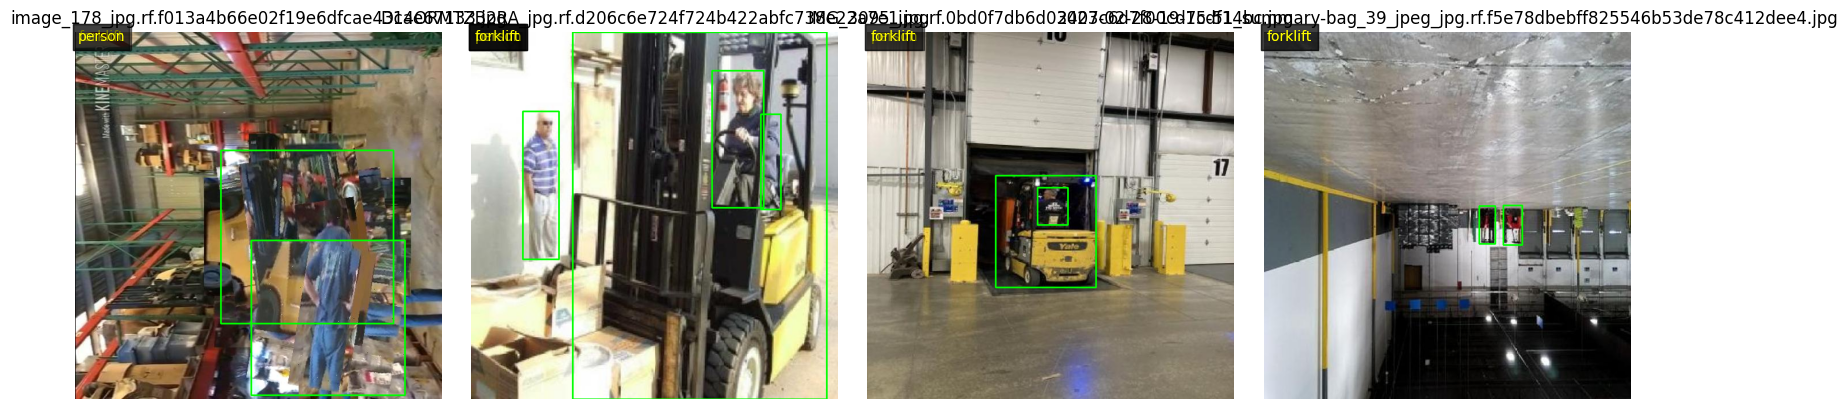

In [36]:
def draw_yolo_bbox(img, bbox, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    cx, cy, bw, bh = bbox
    x1 = int((cx - bw/2) * W)
    y1 = int((cy - bh/2) * H)
    x2 = int((cx + bw/2) * W)
    y2 = int((cy + bh/2) * H)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def visualize_samples(img_dir: str, class_names: list, n=4, seed=42):
    rng = random.Random(seed)
    pairs = yolo_label_paths(img_dir)
    sample = rng.sample(pairs, min(n, len(pairs)))
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
    if len(sample) == 1:
        axes = [axes]
    for ax, (img_path, lbl_path) in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, 15, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir, class_names, n=4, seed=7)

### What methods would you use to verify the reliability of the labels?
# Para verficar la confiabilidad de las etiquetas de analaizará los outliers, para identificar los valores atipicos 

In [37]:
# Emepezaremos con en análisis del area de las etiquetas

def find_iqr_outliers(df: pd.DataFrame, column: str, threshold: float = 1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)
    
    if lower_bound < 0:
        lower_bound = 0
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"--- Análisis IQR para {column} ---")
    print(f"Q1 (25%): {Q1:.6f}")
    print(f"Q3 (75%): {Q3:.6f}")
    print(f"IQR: {IQR:.6f}")
    print(f"Límite Inferior (Outliers pequeños): {lower_bound:.6f}")
    print(f"Límite Superior (Outliers grandes): {upper_bound:.6f}")
    print(f"\nTotal de Outliers detectados: {len(outliers)} ({len(outliers)/len(df) * 100:.2f}%)")
    
    return outliers, lower_bound, upper_bound

# Ejecutar el análisis en las áreas de las bounding boxes
outliers_area_train, lower_limit, upper_limit = find_iqr_outliers(
    df=df_areas_train, 
    column='bbox_area_norm'
)

# Mostrar los outliers más grandes detectados
print("\nOutliers detectados por área (Top 5 más grandes):")
outliers_area_train.sort_values(by='bbox_area_norm', ascending=False).head()

--- Análisis IQR para bbox_area_norm ---
Q1 (25%): 0.010547
Q3 (75%): 0.203203
IQR: 0.192656
Límite Inferior (Outliers pequeños): 0.000000
Límite Superior (Outliers grandes): 0.492187

Total de Outliers detectados: 5239 (10.60%)

Outliers detectados por área (Top 5 más grandes):


,bbox_area_norm
20214,1.0
31668,1.0
31670,1.0
31671,1.0
7269,1.0


In [38]:
# --- Función Modificada para Rastreo de Outliers ---
def analyze_split_with_paths(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    data_list = []

    for img_path, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        for (cls_id, cx, cy, w, h) in labels:
            data_list.append({
                "class_id": cls_id,
                "bbox_area_norm": w * h,
                "image_path": img_path,
                "label_path": lbl_path
            })
    
    df_data = pd.DataFrame(data_list)
    return df_data

# Obtener todos los datos del set de entrenamiento con rutas
df_all_train_data = analyze_split_with_paths(train_dir, class_names)

# Identificar los Outliers con área 1.0 (los más críticos)
outliers_max_area = df_all_train_data[df_all_train_data['bbox_area_norm'] == 1.0]

print(f"Total de objetos con área 1.0 encontrados: {len(outliers_max_area)}")

Total de objetos con área 1.0 encontrados: 187


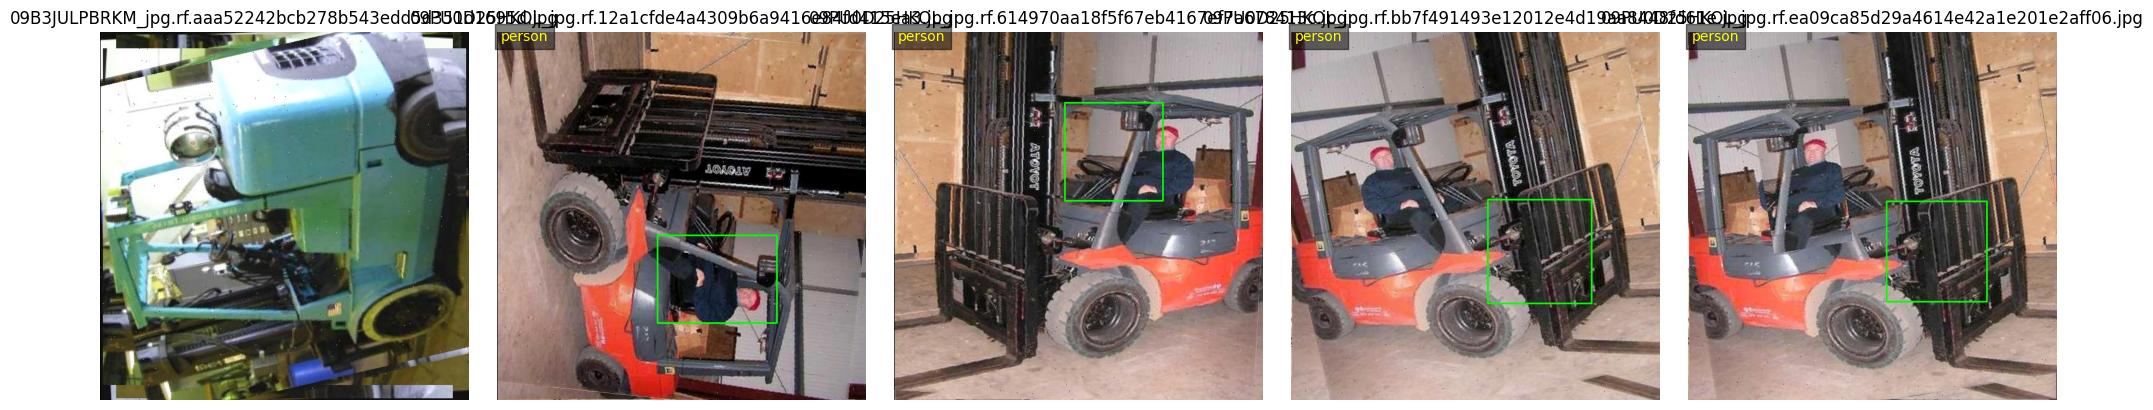

In [40]:
def visualize_specific_samples(image_paths: list, class_names: list):
    """Visualiza una lista específica de imágenes junto con sus etiquetas."""
    n = len(image_paths)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    
    for ax, img_path in zip(axes, image_paths):
        lbl_path = str(Path(img_path).parent.parent / 'labels' / (Path(img_path).stem + ".txt"))

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, 15, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
            
        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()


# Obtener una lista de las rutas únicas de las imágenes con área 1.0
images_to_check = outliers_max_area['image_path'].unique().tolist()

# Visualizar la muestra
visualize_specific_samples(images_to_check[:5], class_names)

In [41]:
# Proceso de limpieza de etiquetas 
import os
from pathlib import Path

# Obtener las rutas de los archivos de etiquetas
label_paths_to_clean = outliers_max_area['label_path'].unique().tolist()
count_removed_lines = 0

for lbl_path in label_paths_to_clean:
    lines_to_keep = []
    
    with open(lbl_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                # Calcula el área normalizada (w * h)
                w, h = float(parts[3]), float(parts[4])
                area = w * h
                
                # Criterio de Eliminación: Si el área es 1.0 o está muy cerca del máximo.
                if area >= 0.999:
                    count_removed_lines += 1
                    continue 
            
            lines_to_keep.append(line)

    with open(lbl_path, 'w') as f:
        f.writelines(lines_to_keep)

print(f"\n✅ Proceso de limpieza finalizado. Se eliminaron {count_removed_lines} etiquetas con área 1.0.")


✅ Proceso de limpieza finalizado. Se eliminaron 0 etiquetas con área 1.0.


In [42]:
# verificacion que se eliminaron las etiquetas con área = 1.0
df_all_train_data = analyze_split_with_paths(train_dir, class_names)
outliers_max_area = df_all_train_data[df_all_train_data['bbox_area_norm'] == 1.0]
print(f"Total de objetos con área 1.0 encontrados: {len(outliers_max_area)}")

Total de objetos con área 1.0 encontrados: 0


In [43]:
# Re-analizar las etiquetas con los archivos labels ya limpios
df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)

# Visualización rápida del nuevo conteo de clases y áreas (Opcional)
print("Nueva distribución de áreas (descriptiva):")
print(df_areas_train.describe())

Nueva distribución de áreas (descriptiva):
       bbox_area_norm
count    49231.000000
mean         0.152396
std          0.218727
min          0.000010
25%          0.010474
50%          0.044844
75%          0.199724
max          0.998437


In [45]:
# Re-ejecutar el análisis IQR 
# Para comprobar que se mejoraron los parámetros
outliers_area_train_nuevo, lower_limit_nuevo, upper_limit_nuevo = find_iqr_outliers(
    df=df_areas_train, 
    column='bbox_area_norm'
)

print("\n--- Outliers detectados (Conteo Total) ---")
print(f"Total de Outliers detectados: {len(outliers_area_train_nuevo)} ({len(outliers_area_train_nuevo)/len(df_areas_train) * 100:.2f}%)")

--- Análisis IQR para bbox_area_norm ---
Q1 (25%): 0.010474
Q3 (75%): 0.199724
IQR: 0.189250
Límite Inferior (Outliers pequeños): 0.000000
Límite Superior (Outliers grandes): 0.483600

Total de Outliers detectados: 5224 (10.61%)

--- Outliers detectados (Conteo Total) ---
Total de Outliers detectados: 5224 (10.61%)


In [46]:
# Ahora analizamos los outliners de la cantidad de etiquetas por imagen "objects_per_image"
def find_iqr_outliers_by_image_count(df: pd.DataFrame, column: str, threshold: float = 1.5):
    """Identifica outliers en una columna usando el método del Rango Intercuartílico (IQR)."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)
    
    # Nos enfocamos en outliers superiores (imágenes con demasiados objetos)
    outliers = df[df[column] > upper_bound]
    
    print(f"--- Análisis IQR para {column} ---")
    print(f"Q1 (25%): {Q1:.2f} objetos")
    print(f"Q3 (75%): {Q3:.2f} objetos")
    print(f"Límite Superior (Outliers densos): {upper_bound:.2f} objetos")
    print(f"\nTotal de imágenes Outliers detectadas: {len(outliers)} ({len(outliers)/len(df) * 100:.2f}%)")
    
    return outliers, upper_bound

df_objs_train_outliers, upper_limit_count = find_iqr_outliers_by_image_count(
    df=df_objs_train, 
    column='objects_per_image'
)

--- Análisis IQR para objects_per_image ---
Q1 (25%): 1.00 objetos
Q3 (75%): 3.00 objetos
Límite Superior (Outliers densos): 6.00 objetos

Total de imágenes Outliers detectadas: 864 (4.21%)


In [ ]:
#funcion para detectar las imagenes a eliminar 
import shutil

train_pairs = yolo_label_paths(train_dir) 

files_to_delete = []
deleted_count = 0

for img_path, lbl_path in train_pairs:
    labels = read_yolo_labels(lbl_path)
    count = len(labels)
    
    # Si la imagen supera el límite superior (6 objetos)
    if count > upper_limit_count:
        files_to_delete.append({
            'img': img_path,
            'lbl': lbl_path,
            'count': count
        })

print(f"Imágenes identificadas para eliminación (más de {upper_limit_count} objetos): {len(files_to_delete)}")

Imágenes identificadas para eliminación (más de 6.0 objetos): 864


In [52]:
#eliminacion de las imagenes detectadas con mas de 6 etiquetas 
for file_info in files_to_delete:
    try:
        os.remove(file_info['img'])
        os.remove(file_info['lbl'])
        deleted_count += 1
    except OSError as e:
        print(f"Error al eliminar {file_info['img']}: {e}")

print(f"Se eliminaron {deleted_count} pares de imagen/etiqueta que excedían el límite de {upper_limit_count} objetos.")

Error al eliminar ../data/train/images/-108_jpg.rf.59e31f270d1aef61adc3198301ef088e.jpg: [Errno 2] No such file or directory: '../data/train/images/-108_jpg.rf.59e31f270d1aef61adc3198301ef088e.jpg'
Error al eliminar ../data/train/images/-108_jpg.rf.87d9811f77687e6111db98402812d9fd.jpg: [Errno 2] No such file or directory: '../data/train/images/-108_jpg.rf.87d9811f77687e6111db98402812d9fd.jpg'
Error al eliminar ../data/train/images/-108_jpg.rf.f8e2654f2d7525e60f708b9eaeb6216c.jpg: [Errno 2] No such file or directory: '../data/train/images/-108_jpg.rf.f8e2654f2d7525e60f708b9eaeb6216c.jpg'
Error al eliminar ../data/train/images/0004210_jpg.rf.1f950822b73a2dab03169b61012ad515.jpg: [Errno 2] No such file or directory: '../data/train/images/0004210_jpg.rf.1f950822b73a2dab03169b61012ad515.jpg'
Error al eliminar ../data/train/images/0004210_jpg.rf.7ed8ad3e82d85a0c501dbca86b9ee5af.jpg: [Errno 2] No such file or directory: '../data/train/images/0004210_jpg.rf.7ed8ad3e82d85a0c501dbca86b9ee5af.jpg

In [49]:
df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(   class_id  count     class_name
 1         2  22626       forklift
 0         8  15788         person
 2         7    231  license plate
 5         0    207            car
 7         1    177  cardboard box,
        objects_per_image
 count       19682.000000
 mean            2.021695
 std             1.221468
 min             0.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max             6.000000,
        bbox_area_norm
 count    39791.000000
 mean         0.179236
 std          0.231169
 min          0.000176
 25%          0.015936
 50%          0.068225
 75%          0.265999
 max          0.998437)

# 2. Training

In [ ]:
# ==============================
# 🔧 HYPERPARAMETERS — EXPERIMENTAL SETUP
# ==============================

# TODO: Fill in the hyperparameters based on your dataset analysis.
# Justify your choices in the Markdown cell above.

EPOCHS = ___
IMGSZ  = ___
BATCH  = ___
DEVICE = "cpu"        # or "cuda" if available

# Try YOLO11; if not available use YOLOv8
weights_try = ["yolo11n.pt", "yolov8n.pt"]
model = None
for w in weights_try:
    try:
        model = YOLO(w)
        print("Using:", w)
        break
    except Exception as e:
        print(f"Failed to load {w}: {e}")

assert model is not None, "Could not load a base model (yolo11n.pt / yolov8n.pt). Install ultralytics and make sure you have an active internet connection to download the weights."


# ==============================
# 🚀 TRAINING — BASELINE EXPERIMENT
# ==============================
# The results object contains metrics, charts, and run directory info.
# Feel free to adjust and rerun with different hyperparameters.

results = model.train(data=DATA_YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, device=DEVICE)
results

### ✏️ Discussion

Explain:
1. Why did you choose these hyperparameters?  
2. How do they affect training time, GPU/CPU usage, and accuracy?  
3. What would you try differently if you had more time or resources?

# 3. Evaluation


> 👉 **Task:** Evaluate your trained model using the validation set defined in `data.yaml`.

Run the following cell to compute key performance metrics
Then, summarize your results and provide your interpretation.

**Guidelines for your analysis:**
- **Quantitative metrics** 
- **Error analysis**
- **Next steps**

In [ ]:
# Put Here your model metrics
# TODO:
# - Run model validation on the dataset below.
# - Capture metrics and save a summary to artifacts/metrics_summary.json.
# - Optionally, add visual analysis (PR curves, confusion matrix).

# Put your model evaluation code here 👇

metrics = model.val(data=DATA_YAML_PATH, imgsz=IMGSZ, device=DEVICE)
try:
    summary = {
        "metrics/mAP50-95(B)": float(metrics.box.map if hasattr(metrics, "box") else getattr(metrics, "map", float("nan"))),
        "metrics/mAP50(B)"   : float(getattr(metrics, "map50", float("nan"))),
        "nc": int(nc),
        "classes": class_names,
        "epochs": EPOCHS,
        "imgsz": IMGSZ,
    }
except Exception as e:
    summary = {"error": str(e)}
    
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

summary


### ✏️ Metrics Interpretation and Analysis

Provide a short written analysis here:

1. **Quantitative Summary:**
   - What are your `mAP50` and `mAP50-95` values?
   - Which classes achieved the highest and lowest detection performance?

2. **Qualitative Analysis:**
   - Describe common failure cases (e.g., small objects missed, overlapping detections, background confusion).
   - Were there any label quality issues or inconsistencies you observed?

3. **Improvement Proposals:**
   - Suggest at least two improvements (data augmentation, loss tuning, class balancing, etc.).
   - How would you validate whether these changes actually help?


# 4. Inference

In [ ]:
VAL_SHOW_N = 4
val_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    val_imgs.extend(glob.glob(os.path.join(val_dir, ext)))
val_imgs = val_imgs[:VAL_SHOW_N]

pred = model.predict(source=val_imgs, imgsz=IMGSZ, conf=0.25)
# Mostrar con matplotlib (usamos 'plot' de ultralytics para guardar)
out_dir = "runs/predict_display"
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(val_imgs), figsize=(4*len(val_imgs), 4))
if len(val_imgs) == 1:
    axes = [axes]
for ax, r in zip(axes, pred):
    im = r.plot()  # numpy array con anotaciones
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. Export and deploy

In [ ]:

export_dir = Path("artifacts")
export_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = None
for p in Path("runs/detect").rglob("weights/best.pt"):
    best_ckpt = p
    break

if best_ckpt and best_ckpt.exists():
    target = export_dir / "model_best.pt"
    target.write_bytes(best_ckpt.read_bytes())
    print("Wheight export to:", target)
else:
    print("'best.pt' not found")

with open(export_dir / "classes.json", "w") as f:
    json.dump({"nc": int(nc), "names": class_names}, f, indent=2)

try:
    _ = model.export(format="onnx", imgsz=IMGSZ)
    onnx_file = None
    for p in Path(".").rglob("*.onnx"):
        onnx_file = p
        break
    if onnx_file:
        (export_dir / "model.onnx").write_bytes(onnx_file.read_bytes())
        print("ONNX export to:", export_dir / "model.onnx")
except Exception as e:
    print("Export ONNX not available:", e)


# 6. TODOs (for the candidate)
- [ ] Analyze the class imbalance and propose strategies (weighting, augmented sampling, focal loss).
- [ ] Tune hyperparameters (epochs, image size, augmentations) to improve mAP.
- [ ] Record key metrics and justify the final baseline.
- [ ] Prepare all necessary artifacts in artifacts/ for the inference service (API).

# 7. Appendix — Notes on relative paths
- This notebook reads data.yaml and infers the paths to images/ and labels/ for train/, val/, and test/.
- If you move data.yaml to another folder, adjust DATA_YAML_PATH.
- If the dataset was downloaded from Roboflow, keep the standard YOLO folder structure.